<a href="https://colab.research.google.com/github/mzaoualim/lobbying_with_LLM/blob/main/steps_lobbying_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain google-generativeai langchain-google-genai python-dotenv chromadb

In [2]:
import os
import io

import pandas as pd
import matplotlib.pyplot as plt
import glob

from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain.document_loaders import DataFrameLoader
from dotenv import load_dotenv

# Getting X (twitter) data

Making a starter dataframe with:
  * US congress (118th) senator list
  * coupled with their official X (twitter) account.

In [ ]:
!mkdir -p '/content/tweets'
%cd '/content/tweets'
from google.colab import files
files.upload()

In [4]:
senators = pd.read_excel('/content/tweets/congress_twitter_118th.xlsx', header=1)

In [5]:
senators

,Name,Link,State,Party
0,"Baldwin, Tammy",https://twitter.com/SenatorBaldwin,WI,D
1,"Barrasso, John",https://twitter.com/SenJohnBarrasso,WY,R
2,"Bennet, Michael F.",https://twitter.com/SenatorBennet,CO,D
3,"Blackburn, Marsha",https://twitter.com/MarshaBlackburn,TN,R
4,"Blumenthal, Richard",https://twitter.com/SenBlumenthal,CT,D
...,...,...,...,...
95,"Welch, Peter",https://twitter.com/PeterWelch,VT,D
96,"Whitehouse, Sheldon",https://twitter.com/SenWhitehouse,RI,D
97,"Wicker, Roger",https://twitter.com/SenatorWicker,MS,R
98,"Wyden, Ron",https://twitter.com/RonWyden,OR,D


In [6]:
for i in range(len(senators)):
  senators.loc[i, 'Twitter_handles']= senators['Link'].str.split('/')[i][-1]

senators

,Name,Link,State,Party,Twitter_handles
0,"Baldwin, Tammy",https://twitter.com/SenatorBaldwin,WI,D,SenatorBaldwin
1,"Barrasso, John",https://twitter.com/SenJohnBarrasso,WY,R,SenJohnBarrasso
2,"Bennet, Michael F.",https://twitter.com/SenatorBennet,CO,D,SenatorBennet
3,"Blackburn, Marsha",https://twitter.com/MarshaBlackburn,TN,R,MarshaBlackburn
4,"Blumenthal, Richard",https://twitter.com/SenBlumenthal,CT,D,SenBlumenthal
...,...,...,...,...,...
95,"Welch, Peter",https://twitter.com/PeterWelch,VT,D,PeterWelch
96,"Whitehouse, Sheldon",https://twitter.com/SenWhitehouse,RI,D,SenWhitehouse
97,"Wicker, Roger",https://twitter.com/SenatorWicker,MS,R,SenatorWicker
98,"Wyden, Ron",https://twitter.com/RonWyden,OR,D,RonWyden


In [ ]:
# intergrate, for each senator, a dataframe of last ~100 tweets.


In [7]:
pd.read_json('/content/tweets/Baldwin_dataset_us-senators-tweets_2024-04-04_02-00-59-377.json').columns

Index(['type', 'id', 'url', 'twitterUrl', 'text', 'retweetCount', 'replyCount',
       'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang',
       'bookmarkCount', 'isReply', 'author', 'extendedEntities', 'entities',
       'isRetweet', 'isQuote', 'media', 'isConversationControlled', 'quoteId',
       'quote', 'retweet', 'inReplyToId'],
      dtype='object')

In [20]:
# for each senator, merging all tweets in on text and group all in global dataframe by author

pd.read_json('/content/tweets/Baldwin_dataset_us-senators-tweets_2024-04-04_02-00-59-377.json')['author'][0]['userName']

'SenatorBaldwin'

In [32]:
''.join(pd.read_json('/content/tweets/Baldwin_dataset_us-senators-tweets_2024-04-04_02-00-59-377.json')['text'])

"Traveling Wisconsin, I’ve seen firsthand the success of my Dairy Business Innovation Initiative in helping dairy processors overcome headwinds and add value to their world-famous dairy products. I’m glad to see the support I secured helping dairy businesses reach new heights. https://t.co/g2UQI37BByWhen I said I’d fight to lower health care costs for Wisconsin families, I meant it. I’m proud that after my investigation into the high cost of inhalers, three of the biggest inhaler manufacturers have capped their inhaler prices at $35/month! https://t.co/urIr8awp0CWisconsin’s veterans, service members, and military families sacrifice so much to keep our country safe. I was proud to honor their service and ensure they have the benefits and support they deserve. ⬇️ https://t.co/orF7kiibQhI was proud to secure resources for the Wisconsin dairy industry to help our processors and farmers innovate their products, reach new markets, and grow our economy. It was great to be with @WICDR today to

In [ ]:
tweet_text = []
tweet_user = []
for file in glob.glob('/content/tweets/*.json'):
  tweet_user.append(pd.read_json(file)['author'][0]['userName'])
  tweet_text.append(''.join(pd.read_json(file)['text']))

db = pd.DataFrame(data=[tweet_user, tweet_text], columns=['users', 'text'])

In [43]:
len(tweet_text)

97

In [44]:
len(tweet_user)

97

In [47]:
db = pd.DataFrame(columns=['Twitter_handles', 'text'])
db['Twitter_handles'] = tweet_user
db['text'] = tweet_text
db


,Twitter_handles,text
0,SenTinaSmith,The Comstock Act is a tool Republicans want to...
1,SteveDaines,My thoughts and prayers are with the people of...
2,SenatorShaheen,Great news! This national clean financing netw...
3,SenFettermanPA,Hamas is confident we're going to capitulate—b...
4,ChrisCoons,"Happy 90th birthday Dr. Jane Goodall, a dedica..."
...,...,...
92,SenSherrodBrown,"America invented the semiconductor, but now th..."
93,ossoff,RT @SenOssoff: Georgia Service Academy Day is ...
94,JohnCornyn,RT @MK_Korinek: ICYMI: ⁦@JohnCornyn⁩ tours ACU...
95,SenAngusKing,RT @211Maine: Please remember that you must ca...


In [71]:
db.to_csv('tweets_db.csv')

In [77]:
# merging tweets and senators in one dataframe
db_all = pd.merge(db, senators, on='Twitter_handles')
db_all.to_csv('tweets_data.csv')

# Gemini AI

In [ ]:
# loading context data
from google.colab import files
files.upload()

In [27]:
# Load environment variables from .env file
load_dotenv()

# Retrieve API key from environment variable
import os
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


context = pd.read_csv('/content/tweets_data.csv')
loader = DataFrameLoader(context)
documents = loader.load()

# Split Texts
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=10)
# texts = text_splitter.split_text(documents)

# Chroma Embeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# vector_index = Chroma.from_texts(texts, embeddings).as_retriever()

# Get User Question
question = 'government funding of energy transition'

# Get Relevant Documents
# docs = vector_index.get_relevant_documents(user_question)

# Define Prompt Template
prompt_template = """
what is the senatorial stance on {question}, return only the list of senators with : probable support, probable opposition, probable neutral position.
return list of twitter handles as python dictionnary with keys: Support, Opposition, Neutral. without further explanation.
Context: \n{context}\n
Question: \{question}\n
"""

# Create Prompt
prompt = PromptTemplate(template=prompt_template, input_variables=['context', 'question'])

# Load QA Chain
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest", temperature=1, api_key=os.environ["GOOGLE_API_KEY"])
# Load QA Chain
chain = load_qa_chain(model, chain_type="stuff", prompt=prompt)
# Get Response
response = chain({"input_documents": documents, "question": question}, return_only_outputs=True)

# Display Answer
print(response)

{'output_text': '```python\n{\n "Support": {\n  "Maria Cantwell": "@SenatorCantwell",\n  "Tammy Duckworth": "@SenDuckworth",\n  "Kirsten Gillibrand": "@SenGillibrand",\n  "Maggie Hassan": "@SenatorHassan",\n  "Mazie Hirono": "@maziehirono",\n  "Tim Kaine": "@timkaine",\n  "Mark Kelly": "@SenMarkKelly",\n  "Amy Klobuchar": "@amyklobuchar",\n  "Ben Ray Luján": "@SenatorLujan",\n  "Ed Markey": "@SenMarkey",\n  "Jeff Merkley": "@SenJeffMerkley",\n  "Chris Murphy": "@ChrisMurphyCT",\n  "Alex Padilla": "@SenAlexPadilla",\n  "Jack Reed": "@SenJackReed",\n  "Bernie Sanders": "@SenSanders",\n  "Brian Schatz": "@SenBrianSchatz",\n  "Chuck Schumer": "@SenSchumer",\n  "Tina Smith": "@SenTinaSmith",\n  "Debbie Stabenow": "@SenStabenow",\n  "Elizabeth Warren": "@SenWarren",\n  "Sheldon Whitehouse": "@SenWhitehouse",\n  "Ron Wyden": "@RonWyden"\n },\n "Opposition": {\n  "John Barrasso": "@SenJohnBarrasso",\n  "Marsha Blackburn": "@MarshaBlackburn",\n  "John Boozman": "@JohnBoozman",\n  "Katie Britt":

# Present finding

In [28]:
for a, b in response.items():
  ans = eval(b.strip('```python\n'))

In [29]:
ans

{'Support': {'Maria Cantwell': '@SenatorCantwell',
  'Tammy Duckworth': '@SenDuckworth',
  'Kirsten Gillibrand': '@SenGillibrand',
  'Maggie Hassan': '@SenatorHassan',
  'Mazie Hirono': '@maziehirono',
  'Tim Kaine': '@timkaine',
  'Mark Kelly': '@SenMarkKelly',
  'Amy Klobuchar': '@amyklobuchar',
  'Ben Ray Luján': '@SenatorLujan',
  'Ed Markey': '@SenMarkey',
  'Jeff Merkley': '@SenJeffMerkley',
  'Chris Murphy': '@ChrisMurphyCT',
  'Alex Padilla': '@SenAlexPadilla',
  'Jack Reed': '@SenJackReed',
  'Bernie Sanders': '@SenSanders',
  'Brian Schatz': '@SenBrianSchatz',
  'Chuck Schumer': '@SenSchumer',
  'Tina Smith': '@SenTinaSmith',
  'Debbie Stabenow': '@SenStabenow',
  'Elizabeth Warren': '@SenWarren',
  'Sheldon Whitehouse': '@SenWhitehouse',
  'Ron Wyden': '@RonWyden'},
 'Opposition': {'John Barrasso': '@SenJohnBarrasso',
  'Marsha Blackburn': '@MarshaBlackburn',
  'John Boozman': '@JohnBoozman',
  'Katie Britt': '@SenKatieBritt',
  'Mike Braun': '@SenatorBraun',
  'Bill Cassidy

In [30]:
for a, b in ans.items():
  print(a, len(ans[a]))

Support 22
Opposition 43
Neutral 1


In [31]:
size = 0
for a, b in ans.items():
  size += len(ans[a])
size

66

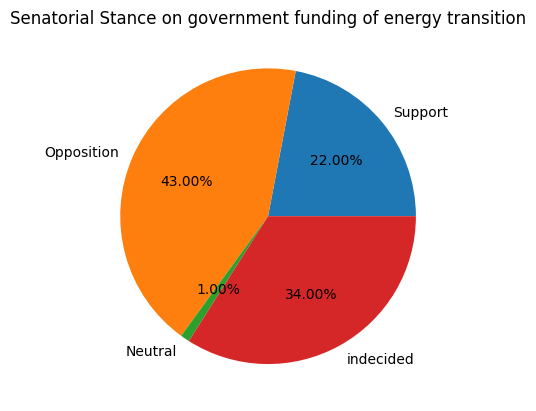

In [33]:
import matplotlib.pyplot as plt

labels = [i for i in ans.keys()] + ['indecided']
sizes = [len(i) for i in ans.values()] + [100-size]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%.2f%%')
plt.title(f'Senatorial Stance on {question}')
plt.show()

# Streamlit App

# Ressources
1.[Understanding RAG: Building a RAG system from scratch with Gemini API](https://medium.com/@saurabhgssinghunderstanding-rag-building-a-rag-system-from-scratch-with-gemini-api-b11ad9fc1bf7)

2.[RAG Application (Gemini)](https://github.com/isurulkh/RAG-application-Gemini)

3.[Building Real-Time Financial News RAG Chatbot with Gemini and Qdrant](https://medium.com/@akriti.upadhyay/building-real-time-financial-news-rag-chatbot-with-gemini-and-qdrant-64c0a3fbe45b)